In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F # funções do Torch
import torch.utils.data

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
X_train = mnist.train.images  # Returns np.array
X_train = np.random.binomial(1,X_train)

X_train = torch.from_numpy(X_train).float() # numpy to torch.tensor


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [88]:
class RBM():
    def __init__(self, nv=784, nh=600, cd_steps=10 ):
        self.W = torch.randn(nv, nh)*0.01
        self.bh = torch.zeros(nh)
        self.bv = torch.zeros(nv)
        self.cd_steps = cd_steps
        self.v= nv
        
    def energy(self, v):
        b_term = v.mv(self.bv)
        linear_tranform = F.linear(v, self.W.t(), self.bh)
        h_term = linear_tranform.exp().add(1).log().sum(1)
        return (-h_term -b_term).mean()
    
    def get_pseudo_likelihood_cost(self,v0,vk):
        loss = self.energy(v0) - self.energy(vk)
        cost = torch.mean( self.v * (torch.sigmoid(loss)).log() )
        return cost
    
    def sample_h(self, x):
        p_h_given_v = torch.sigmoid( F.linear(x, self.W.t(), self.bh) )
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        p_v_given_h = torch.sigmoid(F.linear( y, self.W,self.bv))
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def update(self, v0, vk, ph0, phk):
        learning_rate=0.001
        self.W += learning_rate*(torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk))
        self.bv += learning_rate*(torch.sum((v0-vk), 0))
        self.bh += learning_rate*(torch.sum((ph0-phk), 0))
        
    def gibbs_step(self,v):
        vk = v # inicializa vk
        for k in range(self.cd_steps):
            _,hk = self.sample_h(vk)
            _,vk = self.sample_v(hk)
        return vk
    
    def predict(self,v_sample,steps=5000):
        v = v_sample.clone() # inicializa vk
        for step in range(steps):
            _,h = self.sample_h(v)
            _,v = self.sample_v(h)
        
        return v
        
    
    def fit(self, x_set = None, nb_epoch = 10, batch_size = 100):
        # Training the RBM
        for epoch in range(1, nb_epoch + 1):
            losses = []
            s = 0.
            for id_img in range(0, len(x_set) - batch_size, batch_size):
                x_batch = x_set[id_img:id_img+batch_size]
                
                vk = x_batch
                v0 = x_batch
                ph0,_ = self.sample_h(v0)
                
                vk = self.gibbs_step(vk)
                
                phk,_ = self.sample_h(vk)
                self.update(v0, vk, ph0, phk)
                #vk[x == float("Inf")] = 0
                
                s += 1.
                
                loss = rbm.energy(v0) - rbm.energy(vk) # computa o custo
                losses.append(loss.item())
                
            print('epoch: '+str(epoch)+' loss: '+str( np.mean(losses) ))

In [89]:
rbm = RBM()
rbm.fit(x_set = X_train, nb_epoch = 30)


epoch: 1 loss: -46.485325130608565
epoch: 2 loss: -24.017885079583618
epoch: 3 loss: -19.01474374239562
epoch: 4 loss: -16.479230370026468
epoch: 5 loss: -14.954482948845202
epoch: 6 loss: -13.935637760683488
epoch: 7 loss: -13.106599679192993
epoch: 8 loss: -12.369712454373719
epoch: 9 loss: -11.933982029204378
epoch: 10 loss: -11.579285724132657
epoch: 11 loss: -11.143639236200052
epoch: 12 loss: -10.825543902176543
epoch: 13 loss: -10.51992486561148
epoch: 14 loss: -10.348587119514173
epoch: 15 loss: -10.120468890080687
epoch: 16 loss: -9.988369745417804
epoch: 17 loss: -9.736085707589794
epoch: 18 loss: -9.640815720966387
epoch: 19 loss: -9.507621723446038
epoch: 20 loss: -9.394970947710325
epoch: 21 loss: -9.217391495279058
epoch: 22 loss: -9.14721207193121
epoch: 23 loss: -8.987950114821693
epoch: 24 loss: -8.974685641151526
epoch: 25 loss: -8.839315723634591
epoch: 26 loss: -8.831373815762323
epoch: 27 loss: -8.716925671408953
epoch: 28 loss: -8.615763457529315
epoch: 29 loss: -

In [90]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

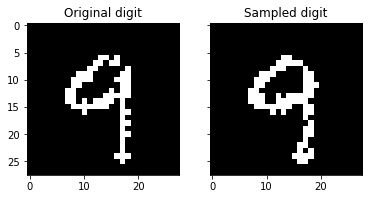

In [118]:

pict = 8

test = X_train[pict]

vk=rbm.predict(test,2)
test= vk.numpy()

show_digit(X_train[pict], test)


In [97]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

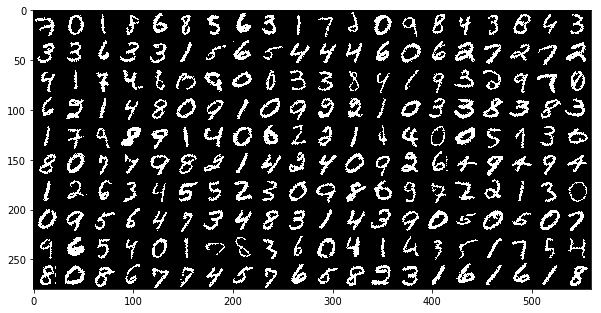

In [103]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train.numpy()),cmap='gray');

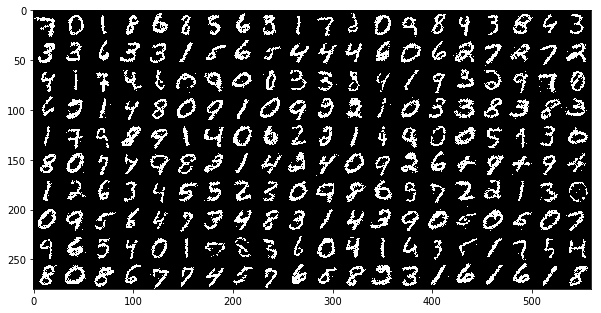

In [116]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(rbm.predict(X[0:200],2).numpy().reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train),cmap='gray')